# Dimensionality Reduction in Trading: Creating a Synthetic Volatility Feature with Kernel PCA

In this notebook, we create multiple volatility indicators using the quantreo library, standardize them properly, and apply a Kernel PCA to extract a single, interpretable synthetic volatility feature. This method helps reduce multicollinearity while retaining essential market information—ideal for building more robust machine learning models in algorithmic trading.

<br>

👉 Full Newsletter about this subject available here: [Click here](https://www.newsletter.quantreo.com/p/the-pca-trick-i-use-all-the-time)

📚 Full course talking about ML for Trading: [Click here](https://www.quantreo.com/ml4trading-course/)

In [71]:
# Import the Features Engineering Package from Quantreo
import quantreo.features_engineering as fe

# Import scikit-learn packages
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

# Import pandas
import pandas as pd

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

# To remove some warnings
import warnings
warnings.filterwarnings("ignore")

In [40]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()
df = df.loc["2016"]

# Show the data
df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

## Create volatility features

In this section, we generate multiple volatility indicators using different statistical estimators (Close-to-Close, Parkinson, Rogers-Satchell, and Yang-Zhang) over various time windows. These features will later be used for dimensionality reduction with PCA.

In [46]:
# Standard volatility features
df["vol_close_to_close_30"] = fe.volatility.close_to_close_volatility(df, window_size=30)
df["vol_close_to_close_60"] = fe.volatility.close_to_close_volatility(df, window_size=60)
df["vol_close_to_close_90"] = fe.volatility.close_to_close_volatility(df, window_size=90)


# Parkinson volatility features
df["vol_parkinson_30"] = fe.volatility.parkinson_volatility(df, high_col="high", low_col="low", window_size=30)
df["vol_parkinson_60"] = fe.volatility.parkinson_volatility(df, high_col="high", low_col="low", window_size=60)
df["vol_parkinson_90"] = fe.volatility.parkinson_volatility(df, high_col="high", low_col="low", window_size=90)


# Rogers Satchell volatility feature
df["vol_rogers_satchell_30"] = fe.volatility.rogers_satchell_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=30)
df["vol_rogers_satchell_60"] = fe.volatility.rogers_satchell_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=60)
df["vol_rogers_satchell_90"] = fe.volatility.rogers_satchell_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=90)

# Yang Zhang volatility feature
df["vol_yang_zhang_30"] = fe.volatility.yang_zhang_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=30)
df["vol_yang_zhang_60"] = fe.volatility.yang_zhang_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=60)
df["vol_yang_zhang_90"] = fe.volatility.yang_zhang_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=90)


# Remove NaN values
df = df.dropna()
df

,open,high,low,close,volume,vol_close_to_close_30,vol_close_to_close_60,vol_close_to_close_90,vol_parkinson_30,vol_parkinson_60,vol_parkinson_90,vol_rogers_satchell_30,vol_rogers_satchell_60,vol_rogers_satchell_90,vol_yang_zhang_30,vol_yang_zhang_60,vol_yang_zhang_90
time,,,,,,,,,,,,,,,,,
2016-02-15 00:00:00,108.987590,109.070169,108.709641,108.907025,660.035859,0.001785,0.001590,0.001584,0.001770,0.001647,0.001633,0.001801,0.001666,0.001662,0.002505,0.002297,0.002289
2016-02-15 04:00:00,108.858099,109.157427,108.846086,109.138406,794.704627,0.001821,0.001606,0.001596,0.001801,0.001662,0.001645,0.001850,0.001690,0.001679,0.002524,0.002309,0.002299
2016-02-15 08:00:00,109.138406,109.261909,109.126550,109.175951,959.457020,0.001792,0.001606,0.001595,0.001821,0.001654,0.001648,0.001846,0.001662,0.001669,0.002580,0.002323,0.002315
2016-02-15 12:00:00,109.175951,109.281245,109.158402,109.278148,1752.989844,0.001785,0.001602,0.001597,0.001801,0.001646,0.001648,0.001836,0.001651,0.001670,0.002545,0.002318,0.002315
2016-02-15 16:00:00,109.278148,109.469441,109.236273,109.440890,1918.783515,0.001673,0.001609,0.001599,0.001801,0.001638,0.001648,0.001835,0.001647,0.001669,0.002544,0.002304,0.002317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484,0.002443,0.001955,0.001770,0.002410,0.002141,0.001925,0.002434,0.002263,0.002003,0.003399,0.002902,0.002628
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475,0.002438,0.001944,0.001742,0.002359,0.002139,0.001927,0.002328,0.002261,0.002007,0.003350,0.002901,0.002628
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665,0.002413,0.001949,0.001744,0.002357,0.002137,0.001904,0.002326,0.002261,0.001989,0.003347,0.002894,0.002591


In [56]:
vol_features = [col for col in df.columns if "vol_" in col and "volatility" not in col]
vol_features

['vol_close_to_close_30',
 'vol_close_to_close_60',
 'vol_close_to_close_90',
 'vol_parkinson_30',
 'vol_parkinson_60',
 'vol_parkinson_90',
 'vol_rogers_satchell_30',
 'vol_rogers_satchell_60',
 'vol_rogers_satchell_90',
 'vol_yang_zhang_30',
 'vol_yang_zhang_60',
 'vol_yang_zhang_90']

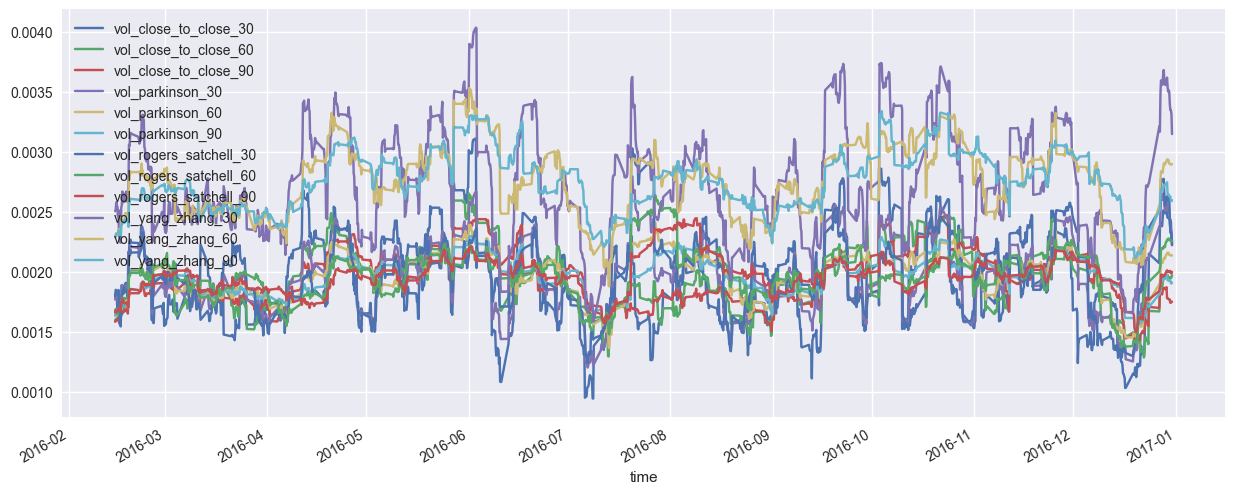

In [86]:
df[vol_features].plot(figsize=(15,6))
plt.show()

<br>

## Split the Data

In this section, we simplify the setup by splitting the dataset into a single train/test split, keeping the chronological order (80% train, 20% test).

In a real-world scenario, especially if you're using walk-forward validation or cross-validation for time series, you'll need to reapply the PCA and standardization process for each train/test pair.

👉 **This is essential to avoid data leakage**: you must always fit the scaler and PCA only on the training data, and then apply the transformations to the test set—never the other way around.

In [47]:
# Define the train size
train_size = int(len(df) * 0.8)

# Chronological split
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# Check the result
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape : {test_df.shape}")

Train set shape: (1094, 17)
Test set shape : (274, 17)


<br>

## Compute the correlation

In this section, we compute the linear correlation matrix between all the volatility features.
As expected, we observe strong correlations, since all features represent different ways of measuring volatility—using various estimators and time windows.

➡️ To reduce redundancy and simplify our feature set, we will combine these correlated variables into a single synthetic volatility feature in the next section using PCA.

In [57]:
# Volatility Features Correlation
train_df[vol_features].corr()

,vol_close_to_close_30,vol_close_to_close_60,vol_close_to_close_90,vol_parkinson_30,vol_parkinson_60,vol_parkinson_90,vol_rogers_satchell_30,vol_rogers_satchell_60,vol_rogers_satchell_90,vol_yang_zhang_30,vol_yang_zhang_60,vol_yang_zhang_90
vol_close_to_close_30,1.000000,0.658094,0.646324,0.776477,0.446810,0.497140,0.435528,0.182276,0.213798,0.907786,0.578932,0.603998
vol_close_to_close_60,0.658094,1.000000,0.826935,0.518322,0.736422,0.617448,0.263288,0.320982,0.240687,0.613556,0.913467,0.769769
vol_close_to_close_90,0.646324,0.826935,1.000000,0.466242,0.583201,0.755090,0.208227,0.219250,0.300686,0.578475,0.745742,0.930691
vol_parkinson_30,0.776477,0.518322,0.466242,1.000000,0.641198,0.585609,0.886313,0.550041,0.486488,0.954019,0.621607,0.560181
vol_parkinson_60,0.446810,0.736422,0.583201,0.641198,1.000000,0.788581,0.586320,0.863499,0.684608,0.581583,0.935582,0.730292
vol_parkinson_90,0.497140,0.617448,0.755090,0.585609,0.788581,1.000000,0.482263,0.654675,0.843140,0.573707,0.749639,0.933161
vol_rogers_satchell_30,0.435528,0.263288,0.208227,0.886313,0.586320,0.482263,1.000000,0.672169,0.558775,0.715710,0.455953,0.363678
vol_rogers_satchell_60,0.182276,0.320982,0.219250,0.550041,0.863499,0.654675,0.672169,1.000000,0.799549,0.392271,0.638537,0.458238
vol_rogers_satchell_90,0.213798,0.240687,0.300686,0.486488,0.684608,0.843140,0.558775,0.799549,1.000000,0.373191,0.492789,0.600923
vol_yang_zhang_30,0.907786,0.613556,0.578475,0.954019,0.581583,0.573707,0.715710,0.392271,0.373191,1.000000,0.643161,0.618389


<br>

## Standardize the data

In this section, we standardize the volatility features before applying PCA.
This step is essential because PCA and Kernel PCA are geometry-based algorithms—they rely on distances and projections in multidimensional space.

📏 Therefore, they are very sensitive to differences in scale between features. Standardizing ensures that each feature contributes equally to the principal components.

In [74]:
# Standardize the features using only the training set
scaler = StandardScaler()
scaler.fit(train_df[vol_features])  # Fit on training data only

# Transform both train and full dataset using the same scaler
train_df_scaled = scaler.transform(train_df[vol_features])
df_vol_scaled = scaler.transform(df[vol_features])

# Convert the scaled full dataset to a DataFrame for easier handling
df_vol_scaled = pd.DataFrame(df_vol_scaled, index=df.index, columns=vol_features)

# Display the standardized volatility features
df_vol_scaled

,vol_close_to_close_30,vol_close_to_close_60,vol_close_to_close_90,vol_parkinson_30,vol_parkinson_60,vol_parkinson_90,vol_rogers_satchell_30,vol_rogers_satchell_60,vol_rogers_satchell_90,vol_yang_zhang_30,vol_yang_zhang_60,vol_yang_zhang_90
time,,,,,,,,,,,,
2016-02-15 00:00:00,-0.401640,-1.381544,-1.576680,-0.666506,-1.700655,-2.118362,-0.579882,-1.549402,-1.925998,-0.541895,-1.561662,-1.836679
2016-02-15 04:00:00,-0.310207,-1.319138,-1.526081,-0.560944,-1.618969,-2.039274,-0.411699,-1.432562,-1.818213,-0.499044,-1.519953,-1.797043
2016-02-15 08:00:00,-0.384208,-1.320118,-1.527724,-0.492111,-1.663043,-2.020514,-0.426479,-1.569616,-1.878487,-0.376898,-1.473607,-1.731616
2016-02-15 12:00:00,-0.400028,-1.335861,-1.521340,-0.561136,-1.705520,-2.020907,-0.461776,-1.625128,-1.872349,-0.454575,-1.489398,-1.732881
2016-02-15 16:00:00,-0.680327,-1.309875,-1.510666,-0.562572,-1.744195,-2.020207,-0.463613,-1.645059,-1.880228,-0.455181,-1.535916,-1.724313
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 04:00:00,1.244838,0.011187,-0.761746,1.512804,0.899999,-0.258326,1.582711,1.446196,0.183129,1.414367,0.478538,-0.492934
2016-12-30 08:00:00,1.231967,-0.029461,-0.884245,1.337949,0.892614,-0.246083,1.221043,1.436164,0.207125,1.306979,0.475796,-0.495787
2016-12-30 12:00:00,1.169592,-0.009815,-0.877716,1.332142,0.878060,-0.391666,1.215668,1.432973,0.092471,1.301821,0.453419,-0.642294


<br>

## Apply the PCA

In this section, we apply Kernel PCA to combine all the standardized volatility features into a single synthetic variable.

By training the PCA model only on the training set, we ensure no data leakage.
We then transform the full dataset using the same projection.

🎯 The result is a new column, volatility, which captures the common dynamics across all volatility estimators—providing a clean, compact, and interpretable feature for modeling.

In [63]:
# Call the PCA method from scikit learn
pca = KernelPCA(n_components=1)

# Train the PCA on the train set
pca.fit(train_df_scaled)

# Apply the PCA on the whole dataset
df["volatility"] = pca.transform(df_vol_scaled)
df

,open,high,low,close,volume,vol_close_to_close_30,vol_close_to_close_60,vol_close_to_close_90,vol_parkinson_30,vol_parkinson_60,vol_parkinson_90,vol_rogers_satchell_30,vol_rogers_satchell_60,vol_rogers_satchell_90,vol_yang_zhang_30,vol_yang_zhang_60,vol_yang_zhang_90,volatility
time,,,,,,,,,,,,,,,,,,
2016-02-15 00:00:00,108.987590,109.070169,108.709641,108.907025,660.035859,0.001785,0.001590,0.001584,0.001770,0.001647,0.001633,0.001801,0.001666,0.001662,0.002505,0.002297,0.002289,-4.614981
2016-02-15 04:00:00,108.858099,109.157427,108.846086,109.138406,794.704627,0.001821,0.001606,0.001596,0.001801,0.001662,0.001645,0.001850,0.001690,0.001679,0.002524,0.002309,0.002299,-4.340453
2016-02-15 08:00:00,109.138406,109.261909,109.126550,109.175951,959.457020,0.001792,0.001606,0.001595,0.001821,0.001654,0.001648,0.001846,0.001662,0.001669,0.002580,0.002323,0.002315,-4.328625
2016-02-15 12:00:00,109.175951,109.281245,109.158402,109.278148,1752.989844,0.001785,0.001602,0.001597,0.001801,0.001646,0.001648,0.001836,0.001651,0.001670,0.002545,0.002318,0.002315,-4.419657
2016-02-15 16:00:00,109.278148,109.469441,109.236273,109.440890,1918.783515,0.001673,0.001609,0.001599,0.001801,0.001638,0.001648,0.001835,0.001647,0.001669,0.002544,0.002304,0.002317,-4.515242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484,0.002443,0.001955,0.001770,0.002410,0.002141,0.001925,0.002434,0.002263,0.002003,0.003399,0.002902,0.002628,1.991279
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475,0.002438,0.001944,0.001742,0.002359,0.002139,0.001927,0.002328,0.002261,0.002007,0.003350,0.002901,0.002628,1.772922
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665,0.002413,0.001949,0.001744,0.002357,0.002137,0.001904,0.002326,0.002261,0.001989,0.003347,0.002894,0.002591,1.625629


<br>

## Plot the result
In this section, we plot the newly created PCA-based volatility feature alongside a few selected original volatility indicators.

This visual comparison allows us to see how the PCA feature captures the overall structure and dynamic behavior of multiple volatility estimators, while reducing the dimensionality of our dataset.

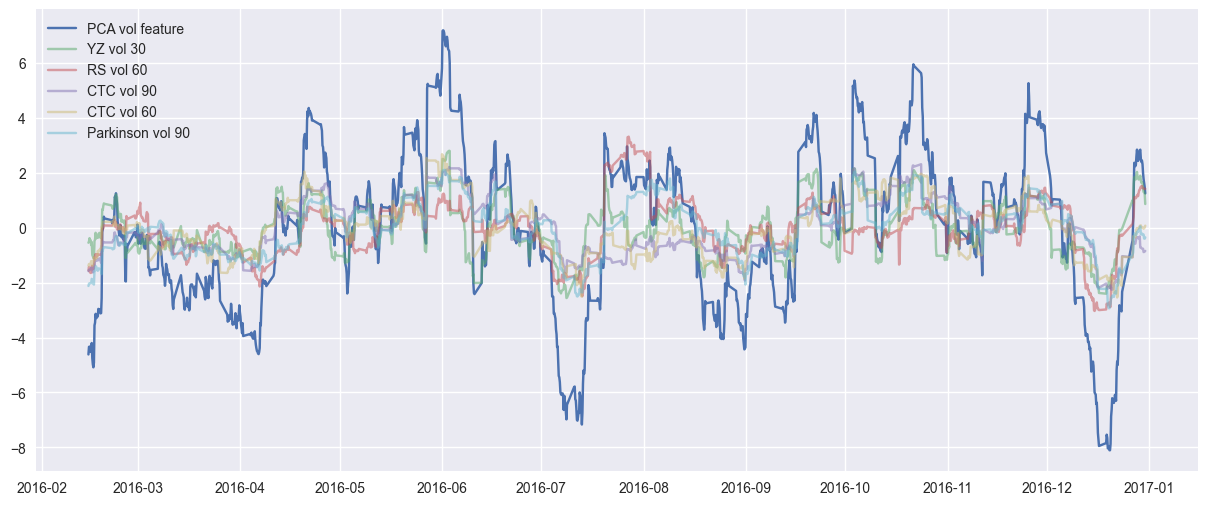

In [84]:
# Plot the result
plt.figure(figsize=(15,6))
plt.plot(df["volatility"], label="PCA vol feature")
plt.plot(df_vol_scaled["vol_yang_zhang_30"], label="YZ vol 30", alpha=0.5)
plt.plot(df_vol_scaled["vol_rogers_satchell_60"], label="RS vol 60", alpha=0.5)
plt.plot(df_vol_scaled["vol_close_to_close_90"], label="CTC vol 90", alpha=0.5)
plt.plot(df_vol_scaled["vol_close_to_close_60"], label="CTC vol 60", alpha=0.5)
plt.plot(df_vol_scaled["vol_parkinson_90"], label="Parkinson vol 90", alpha=0.5)
plt.legend()
plt.show()

We created several volatility indicators and observed strong correlations between them.
To reduce redundancy, we applied Kernel PCA (after proper standardization) to generate one synthetic volatility feature.
This new feature captures the overall market volatility in a compact and interpretable way.

It can now be used as a robust input for any predictive or risk model.

In real trading pipelines, this PCA+scaling process must be repeated on each train/test split to avoid data leakage